# Baseline Code for Deepfake Detection


By Dongmin Kim

## Data Setups

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import sys, os
import pandas as pd
from contextlib import contextmanager
tf.compat.v1.disable_eager_execution()
np.random.seed(42)

In [2]:
gpu_id = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
physical_devices = tf.config.experimental.get_visible_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_gpu_available()

True

## Training

In [5]:
BGR = lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [6]:
VALID_RATIO = 0.1
TEST_RATIO = 0.1
BATCH_SIZE = 32
EPOCHS = 300
TOTAL_DATA_SIZE = 20000

In [7]:
data_gen_args = dict(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, 
    zoom_range=0.1, 
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split = VALID_RATIO,
)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **data_gen_args,
    preprocessing_function = BGR
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function = BGR
)

In [8]:
seed = 42
#path = "/media/data1/hsm/FACE_FORENSICS_C40/DATA_FRAMES/"
path = "./TK_diff"
real_data_dir = os.path.join(path, 'REAL')
fake_data_dir = os.path.join(path, 'FAKE', 'NeuralTextures')

real_filenames = np.array([os.path.join('REAL', f) for f in os.listdir(real_data_dir)])
fake_filenames = np.array([os.path.join('FAKE', 'NeuralTextures', f) for f in os.listdir(fake_data_dir)])

print("FROM DIR")
print("REAL: ", len(real_filenames))
print("FAKE: ", len(fake_filenames))
print("TOTAL: ", len(real_filenames) + len(fake_filenames))

FROM DIR
REAL:  10000
FAKE:  10000
TOTAL:  20000


In [9]:
# random sampling
real_filenames = np.random.choice(real_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()
fake_filenames = np.random.choice(fake_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()

In [10]:
print("TRIM SIZE")
print("REAL: ", len(real_filenames))
print("FAKE: ", len(fake_filenames))
print("TOTAL: ", len(real_filenames) + len(fake_filenames))

total_length = len(real_filenames) + len(fake_filenames)

test_length = int(total_length * TEST_RATIO)
validation_length = int((total_length-test_length) * VALID_RATIO)
train_length = total_length - validation_length - test_length

print("TRAIN: ", train_length, "VALIDATION: ", validation_length, "TEST: ", test_length)

TRIM SIZE
REAL:  10000
FAKE:  10000
TOTAL:  20000
TRAIN:  16200 VALIDATION:  1800 TEST:  2000


## Test Dataset Separation

In [11]:
import cv2

In [12]:
real_filenames_test = real_filenames[:test_length//2]
fake_filenames_test = fake_filenames[:test_length//2]
real_filenames = real_filenames[test_length//2:]
fake_filenames = fake_filenames[test_length//2:]

In [13]:
real_categories_test = []
for filename in real_filenames_test:
    real_categories_test.append('0')
        
real_testdata = pd.DataFrame({'filename' : real_filenames_test, 'label' : real_categories_test})

In [14]:
fake_categories_test = []
for filename in fake_filenames_test:
    fake_categories_test.append('1')

fake_testdata = pd.DataFrame({'filename' : fake_filenames_test, 'label' : fake_categories_test})

In [15]:
test_data = pd.concat([real_testdata, fake_testdata])

In [16]:
# real : 0, fake : 1
categories = []
for filename in real_filenames:
    categories.append('0')
    
for filename in fake_filenames:
    categories.append('1')

In [17]:
data = pd.DataFrame({'filename' : real_filenames + fake_filenames, 'label' : categories})

In [18]:
data

,filename,label
0,REAL/16__podium_speech_happy_frame1145.jpg,0
1,REAL/11__talking_against_wall_frame30.jpg,0
2,REAL/133_frame456.jpg,0
3,REAL/05__talking_against_wall_frame300.jpg,0
4,REAL/672_frame354.jpg,0
...,...,...
17995,FAKE/NeuralTextures/211_177_frame120.jpg,1
17996,FAKE/NeuralTextures/727_729_frame370.jpg,1
17997,FAKE/NeuralTextures/314_347_frame318.jpg,1
17998,FAKE/NeuralTextures/546_621_frame210.jpg,1


In [19]:
data = data.iloc[np.random.RandomState(seed = 42).permutation(len(data))]

In [20]:
data

,filename,label
2574,REAL/794_frame430.jpg,0
7496,REAL/540_frame170.jpg,0
9210,FAKE/NeuralTextures/104_126_frame78.jpg,1
5456,REAL/01__kitchen_still_frame250.jpg,0
736,REAL/241_frame210.jpg,0
...,...,...
11284,FAKE/NeuralTextures/234_187_frame102.jpg,1
11964,FAKE/NeuralTextures/118_120_frame125.jpg,1
5390,REAL/744_frame84.jpg,0
860,REAL/074_frame35.jpg,0


In [21]:
test_data

,filename,label
0,REAL/07__talking_angry_couch_frame1500.jpg,0
1,REAL/385_frame72.jpg,0
2,REAL/06__walk_down_hall_angry_frame20.jpg,0
3,REAL/825_frame420.jpg,0
4,REAL/994_frame25.jpg,0
...,...,...
995,FAKE/NeuralTextures/949_868_frame72.jpg,1
996,FAKE/NeuralTextures/579_701_frame96.jpg,1
997,FAKE/NeuralTextures/271_264_frame90.jpg,1
998,FAKE/NeuralTextures/712_716_frame340.jpg,1


In [22]:
test_data.groupby(['label']).size()

label
0    1000
1    1000
dtype: int64

In [23]:
train_generator = datagen.flow_from_dataframe(
    dataframe = data,
    directory = path,
    x_col = 'filename',
    y_col = 'label',
    target_size =(256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle = True,
    subset = 'training'
)


validation_generator = datagen.flow_from_dataframe(
    dataframe = data,
    directory = path,
    x_col = 'filename',
    y_col = 'label',
    target_size =(256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle = True,
    subset = 'validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = path,
    x_col = 'filename',
    y_col = 'label',
    target_size =(256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
)

Found 16200 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [24]:
# import available models for training
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception

In [25]:
def setupmodel():
    input_tensor = Input(shape = (256,256,3))

    base_model = Xception(
    weights = 'imagenet',
    include_top = False,
    input_tensor = input_tensor
    )
    # Setup
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation = "relu")(x)
    prediction = Dense(1, activation="sigmoid")(x)

    # model return
    model = Model(base_model.input, prediction)

    # trainable
    for l in base_model.layers:
        l.trainable = True

    return model

In [26]:
model = setupmodel()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

In [29]:
class CyclicLR(tf.keras.callbacks.Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [30]:
def train_model(model, train_generator, validation_generator, test_generator, optimizer):
    # checkpointing
    filename = 'checkpoint-TK_diff-smalldata.h5'
    checkpoint = ModelCheckpoint(
                        filename, 
                        monitor='val_loss',
                        verbose=1,           
                        save_best_only=True,
                        mode='auto'
                )
    # early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    # Cyclic Learning Rate
    clr = CyclicLR(
        base_lr=1e-3,#0.001, 
        max_lr=7e-3,#0.007,
        step_size=300., 
        mode='exp_range',
        gamma=0.99994
    )
    
    # compile
    model.compile(
        optimizer = optimizer,
        loss = 'binary_crossentropy',
        metrics=['accuracy'],
    )
    
    # train
    print("== Start Training ==")
    history = model.fit(
        train_generator,
        steps_per_epoch = train_length // BATCH_SIZE, 
        epochs = EPOCHS,
        validation_data = validation_generator,
        validation_steps = validation_length // BATCH_SIZE,
        callbacks=[checkpoint, clr],
    )
    
    return history

In [31]:
history = train_model(model, train_generator, validation_generator, test_generator, tf.keras.optimizers.Adam(lr = 1e-3))

== Start Training ==
Epoch 1/300
505/506 [============================>.] - ETA: 0s - loss: 0.7132 - accuracy: 0.5025
Epoch 00001: val_loss improved from inf to 0.80748, saving model to checkpoint-TK_diff-smalldata.h5
506/506 [==============================] - 327s 646ms/step - loss: 0.7132 - accuracy: 0.5024 - val_loss: 0.8075 - val_accuracy: 0.5084
Epoch 2/300
505/506 [============================>.] - ETA: 0s - loss: 0.6898 - accuracy: 0.5169
Epoch 00002: val_loss improved from 0.80748 to 0.69039, saving model to checkpoint-TK_diff-smalldata.h5
506/506 [==============================] - 277s 547ms/step - loss: 0.6898 - accuracy: 0.5169 - val_loss: 0.6904 - val_accuracy: 0.5117
Epoch 3/300
505/506 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.5259
Epoch 00003: val_loss did not improve from 0.69039
506/506 [==============================] - 277s 548ms/step - loss: 0.6883 - accuracy: 0.5260 - val_loss: 0.6965 - val_accuracy: 0.4967
Epoch 4/300
505/506 [=======

Epoch 30/300
505/506 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5134
Epoch 00030: val_loss did not improve from 0.69039
506/506 [==============================] - 276s 545ms/step - loss: 0.6928 - accuracy: 0.5134 - val_loss: 0.7043 - val_accuracy: 0.5045
Epoch 31/300
505/506 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5194
Epoch 00031: val_loss improved from 0.69039 to 0.68417, saving model to checkpoint-TK_diff-smalldata.h5
506/506 [==============================] - 279s 551ms/step - loss: 0.6888 - accuracy: 0.5194 - val_loss: 0.6842 - val_accuracy: 0.5592
Epoch 32/300
505/506 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5353
Epoch 00032: val_loss did not improve from 0.68417
506/506 [==============================] - 272s 538ms/step - loss: 0.6840 - accuracy: 0.5351 - val_loss: 0.6868 - val_accuracy: 0.5240
Epoch 33/300
505/506 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.53

505/506 [============================>.] - ETA: 0s - loss: 0.6494 - accuracy: 0.6045
Epoch 00057: val_loss did not improve from 0.65245
506/506 [==============================] - 380s 750ms/step - loss: 0.6494 - accuracy: 0.6046 - val_loss: 0.6545 - val_accuracy: 0.6055
Epoch 58/300
505/506 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.6068
Epoch 00058: val_loss did not improve from 0.65245
506/506 [==============================] - 388s 767ms/step - loss: 0.6523 - accuracy: 0.6069 - val_loss: 0.6581 - val_accuracy: 0.6077
Epoch 59/300
505/506 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.6078
Epoch 00059: val_loss did not improve from 0.65245
506/506 [==============================] - 379s 749ms/step - loss: 0.6461 - accuracy: 0.6078 - val_loss: 0.6537 - val_accuracy: 0.6027
Epoch 60/300
505/506 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.6135
Epoch 00060: val_loss did not improve from 0.65245
506/506 [===

Epoch 85/300
505/506 [============================>.] - ETA: 0s - loss: 0.5964 - accuracy: 0.6673
Epoch 00085: val_loss improved from 0.60730 to 0.60378, saving model to checkpoint-TK_diff-smalldata.h5
506/506 [==============================] - 379s 749ms/step - loss: 0.5965 - accuracy: 0.6672 - val_loss: 0.6038 - val_accuracy: 0.6546
Epoch 86/300
505/506 [============================>.] - ETA: 0s - loss: 0.5957 - accuracy: 0.6617
Epoch 00086: val_loss did not improve from 0.60378
506/506 [==============================] - 370s 732ms/step - loss: 0.5957 - accuracy: 0.6616 - val_loss: 0.6138 - val_accuracy: 0.6445
Epoch 87/300
505/506 [============================>.] - ETA: 0s - loss: 0.5906 - accuracy: 0.6681
Epoch 00087: val_loss improved from 0.60378 to 0.60030, saving model to checkpoint-TK_diff-smalldata.h5
506/506 [==============================] - 394s 779ms/step - loss: 0.5907 - accuracy: 0.6682 - val_loss: 0.6003 - val_accuracy: 0.6512
Epoch 88/300
505/506 [====================

Epoch 112/300
505/506 [============================>.] - ETA: 0s - loss: 0.5266 - accuracy: 0.7240
Epoch 00112: val_loss did not improve from 0.56333
506/506 [==============================] - 398s 786ms/step - loss: 0.5268 - accuracy: 0.7238 - val_loss: 0.5693 - val_accuracy: 0.6936
Epoch 113/300
505/506 [============================>.] - ETA: 0s - loss: 0.5239 - accuracy: 0.7235
Epoch 00113: val_loss improved from 0.56333 to 0.56199, saving model to checkpoint-TK_diff-smalldata.h5
506/506 [==============================] - 385s 760ms/step - loss: 0.5242 - accuracy: 0.7232 - val_loss: 0.5620 - val_accuracy: 0.6942
Epoch 114/300
505/506 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.7226
Epoch 00114: val_loss did not improve from 0.56199
506/506 [==============================] - 383s 757ms/step - loss: 0.5269 - accuracy: 0.7227 - val_loss: 0.5624 - val_accuracy: 0.6964
Epoch 115/300
505/506 [============================>.] - ETA: 0s - loss: 0.5179 - accuracy: 

505/506 [============================>.] - ETA: 0s - loss: 0.4383 - accuracy: 0.7920
Epoch 00140: val_loss did not improve from 0.53940
506/506 [==============================] - 366s 723ms/step - loss: 0.4384 - accuracy: 0.7921 - val_loss: 0.5548 - val_accuracy: 0.7137
Epoch 141/300
505/506 [============================>.] - ETA: 0s - loss: 0.4261 - accuracy: 0.7960
Epoch 00141: val_loss did not improve from 0.53940
506/506 [==============================] - 403s 797ms/step - loss: 0.4261 - accuracy: 0.7959 - val_loss: 0.5547 - val_accuracy: 0.7299
Epoch 142/300
505/506 [============================>.] - ETA: 0s - loss: 0.4160 - accuracy: 0.7998
Epoch 00142: val_loss did not improve from 0.53940
506/506 [==============================] - 367s 726ms/step - loss: 0.4158 - accuracy: 0.7997 - val_loss: 0.5443 - val_accuracy: 0.7294
Epoch 143/300
505/506 [============================>.] - ETA: 0s - loss: 0.4156 - accuracy: 0.8026
Epoch 00143: val_loss did not improve from 0.53940
506/506 [

Epoch 169/300
505/506 [============================>.] - ETA: 0s - loss: 0.3272 - accuracy: 0.8499
Epoch 00169: val_loss did not improve from 0.53940
506/506 [==============================] - 271s 535ms/step - loss: 0.3269 - accuracy: 0.8501 - val_loss: 0.6931 - val_accuracy: 0.7104
Epoch 170/300
505/506 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8667
Epoch 00170: val_loss did not improve from 0.53940
506/506 [==============================] - 272s 538ms/step - loss: 0.2950 - accuracy: 0.8666 - val_loss: 0.6619 - val_accuracy: 0.7132
Epoch 171/300
505/506 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.8653
Epoch 00171: val_loss did not improve from 0.53940
506/506 [==============================] - 273s 540ms/step - loss: 0.2988 - accuracy: 0.8654 - val_loss: 0.7338 - val_accuracy: 0.7148
Epoch 172/300
505/506 [============================>.] - ETA: 0s - loss: 0.2927 - accuracy: 0.8703
Epoch 00172: val_loss did not improve from 0.5

Epoch 198/300
505/506 [============================>.] - ETA: 0s - loss: 0.2345 - accuracy: 0.8945
Epoch 00198: val_loss did not improve from 0.53940
506/506 [==============================] - 272s 537ms/step - loss: 0.2345 - accuracy: 0.8946 - val_loss: 0.7445 - val_accuracy: 0.7249
Epoch 199/300
505/506 [============================>.] - ETA: 0s - loss: 0.2191 - accuracy: 0.9062
Epoch 00199: val_loss did not improve from 0.53940
506/506 [==============================] - 271s 535ms/step - loss: 0.2190 - accuracy: 0.9064 - val_loss: 0.7457 - val_accuracy: 0.7422
Epoch 200/300
505/506 [============================>.] - ETA: 0s - loss: 0.2218 - accuracy: 0.9034
Epoch 00200: val_loss did not improve from 0.53940
506/506 [==============================] - 275s 543ms/step - loss: 0.2216 - accuracy: 0.9036 - val_loss: 0.7042 - val_accuracy: 0.7260
Epoch 201/300
505/506 [============================>.] - ETA: 0s - loss: 0.2256 - accuracy: 0.8995
Epoch 00201: val_loss did not improve from 0.5

Epoch 227/300
505/506 [============================>.] - ETA: 0s - loss: 0.2014 - accuracy: 0.9135
Epoch 00227: val_loss did not improve from 0.53940
506/506 [==============================] - 272s 538ms/step - loss: 0.2015 - accuracy: 0.9135 - val_loss: 0.8706 - val_accuracy: 0.7232
Epoch 228/300
505/506 [============================>.] - ETA: 0s - loss: 0.1575 - accuracy: 0.9318
Epoch 00228: val_loss did not improve from 0.53940
506/506 [==============================] - 275s 544ms/step - loss: 0.1577 - accuracy: 0.9318 - val_loss: 0.9427 - val_accuracy: 0.7310
Epoch 229/300
505/506 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9350
Epoch 00229: val_loss did not improve from 0.53940
506/506 [==============================] - 271s 535ms/step - loss: 0.1459 - accuracy: 0.9350 - val_loss: 1.0847 - val_accuracy: 0.7204
Epoch 230/300
505/506 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9440
Epoch 00230: val_loss did not improve from 0.5

Epoch 256/300
505/506 [============================>.] - ETA: 0s - loss: 0.1408 - accuracy: 0.9425
Epoch 00256: val_loss did not improve from 0.53940
506/506 [==============================] - 270s 534ms/step - loss: 0.1408 - accuracy: 0.9425 - val_loss: 0.8475 - val_accuracy: 0.7254
Epoch 257/300
505/506 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9456
Epoch 00257: val_loss did not improve from 0.53940
506/506 [==============================] - 276s 546ms/step - loss: 0.1282 - accuracy: 0.9456 - val_loss: 0.9721 - val_accuracy: 0.7316
Epoch 258/300
505/506 [============================>.] - ETA: 0s - loss: 0.1096 - accuracy: 0.9533
Epoch 00258: val_loss did not improve from 0.53940
506/506 [==============================] - 272s 538ms/step - loss: 0.1097 - accuracy: 0.9533 - val_loss: 1.0115 - val_accuracy: 0.7338
Epoch 259/300
505/506 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9355
Epoch 00259: val_loss did not improve from 0.5

Epoch 285/300
505/506 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9754
Epoch 00285: val_loss did not improve from 0.53940
506/506 [==============================] - 275s 543ms/step - loss: 0.0664 - accuracy: 0.9754 - val_loss: 1.8194 - val_accuracy: 0.7165
Epoch 286/300
505/506 [============================>.] - ETA: 0s - loss: 0.0726 - accuracy: 0.9719
Epoch 00286: val_loss did not improve from 0.53940
506/506 [==============================] - 275s 543ms/step - loss: 0.0726 - accuracy: 0.9719 - val_loss: 2.2151 - val_accuracy: 0.7478
Epoch 287/300
505/506 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9750
Epoch 00287: val_loss did not improve from 0.53940
506/506 [==============================] - 269s 531ms/step - loss: 0.0710 - accuracy: 0.9750 - val_loss: 1.4719 - val_accuracy: 0.7338
Epoch 288/300
505/506 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9767
Epoch 00288: val_loss did not improve from 0.5

**Plot Results**

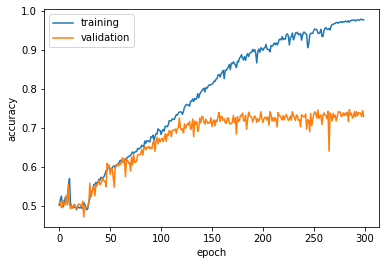

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

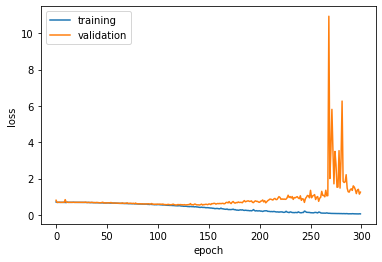

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

In [34]:
model = setupmodel()
json_filename = "TK_diff_model.json"

In [35]:
model_json = model.to_json()
with open(json_filename, "w") as json_file : 
    json_file.write(model_json)

In [36]:
from tensorflow.keras.models import model_from_json 
json_file = open(json_filename, "r") 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json)

In [37]:
loaded_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 1e-3),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)
loaded_model.load_weights("checkpoint-TK_diff-smalldata.h5")

### Metrics - F1, Recall, Precision

In [38]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from tqdm import tqdm, trange

In [39]:
print("== Evaluate ==")

output_score = []
output_class = []
answer_class = []

for i in trange(len(test_generator)):
    output = loaded_model.predict_on_batch(test_generator[i][0])
    output_score.append(output)
    answer_class.append(test_generator[i][1])
    
output_score = np.concatenate(output_score)
answer_class = np.concatenate(answer_class)

lst = []
for i in output_score:
    val = i[0]
    sublst = [1-val, val]
    lst.append(sublst)
    
output_score = np.array(lst)

print(output_score)
print(answer_class)

output_class = np.argmax(output_score, axis=1)

print(output_class)
print(answer_class)

  0%|          | 0/63 [00:00<?, ?it/s]

== Evaluate ==


100%|██████████| 63/63 [00:20<00:00,  3.10it/s]

[[9.77676421e-01 2.23235786e-02]
 [9.99998599e-01 1.40070915e-06]
 [9.37896550e-01 6.21034503e-02]
 ...
 [9.99948740e-01 5.12599945e-05]
 [5.16548187e-01 4.83451813e-01]
 [2.99864411e-01 7.00135589e-01]]
[0. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 1]
[0. 0. 0. ... 0. 0. 0.]


In [40]:
print(len(answer_class))

cnt = np.sum(answer_class)
print(cnt)

print(len(output_class))
cnt2= np.sum(output_class)
print(cnt2)

2000
1000.0
2000
954


In [41]:
cm = confusion_matrix(answer_class, output_class)
report = classification_report(answer_class, output_class)

recall = cm[0][0] / (cm[0][0] + cm[0][1])
fallout = cm[1][0] / (cm[1][0] + cm[1][1])

fpr, tpr, thresholds = roc_curve(answer_class, output_score[:, 1], pos_label=1.)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

print(report)
print(cm)
print("AUROC: %f" %(roc_auc_score(answer_class, output_score[:, 1])))
print("THRESH: " , thresh)
print('test_acc: ', len(output_class[np.equal(output_class, answer_class)]) / len(output_class))

              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70      1000
         1.0       0.70      0.67      0.69      1000

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000

[[717 283]
 [329 671]]
AUROC: 0.783181
THRESH:  0.4633271793524424
test_acc:  0.694
